In [30]:
#TODO: normalize to 410 secs

sec_norm = 410
n = 30  # Number of values to predict at a time
input_size = n  # Input is a window of size n
hidden_size = 50 #variable k
output_size = n  # Output is a window of size n
num_epochs = 100
batch_size = 16
learning_rate = 0.001
cutoff = 50 #cutting of time it takes to lift off
norm_upper = 4
norm_lower = 2
train_dir = (['data/5-2-25/','data/31-1-25/'])
test_dir = (['data/21-2-25/'])

In [31]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import maketab as mt
from torch.utils.data import Dataset, DataLoader

In [32]:
def norm(signal):
    signal = (signal - norm_lower) / (norm_upper - norm_lower)
    return signal

def load_data(path_dir):
    t, signal = mt.battery(path_dir)
    secleft = t[-1]/1000
    tleft = 1 - t / max(t)
    tleft = tleft*(secleft/sec_norm)
    signal = norm(signal[cutoff:])
    tleft = tleft[cutoff:]
    t = t[cutoff:]
    normalized_train = [signal, tleft, t]
    return normalized_train

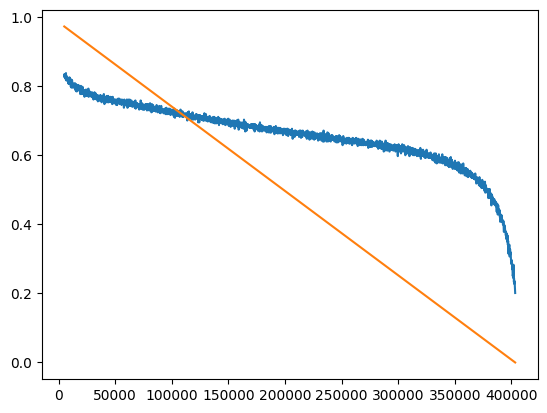

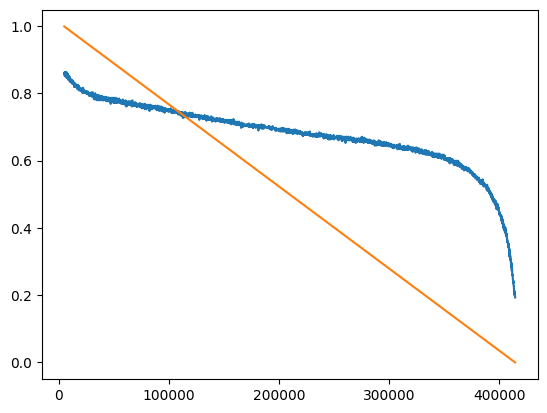

In [33]:
for d in train_dir:
    train_data = load_data(d)
    plt.plot(train_data[2], train_data[0])
    plt.plot(train_data[2], train_data[1])
    plt.show()

In [34]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

def prep_data(data):
    # Convert to PyTorch tensors
    f_tensor = torch.tensor(data[0], dtype=torch.float32) #signal
    g_tensor = torch.tensor(data[1], dtype=torch.float32) #tleft
    
    # Create sliding windows of size n
    X = []
    Y = []
    for i in range(len(data[0]) - n):
        X.append(f_tensor[i:i+n])  # Input window of size n
        Y.append(g_tensor[i:i+n])  # Target window of size n
    
    # Stack into tensors
    X = torch.stack(X)
    Y = torch.stack(Y)
    dataset = TimeSeriesDataset(X, Y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [35]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Initialize model
model = MLP(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [36]:
def train(num_epochs, dataloader, model, criterion, optimizer):
    for epoch in range(num_epochs):
        for batch_X, batch_Y in dataloader:
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
    
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

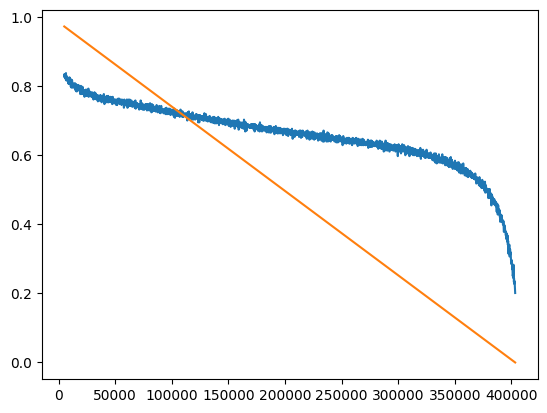

Epoch [10/100], Loss: 0.0061
Epoch [20/100], Loss: 0.0001
Epoch [30/100], Loss: 0.0003
Epoch [40/100], Loss: 0.0013
Epoch [50/100], Loss: 0.0001
Epoch [60/100], Loss: 0.0003
Epoch [70/100], Loss: 0.0017
Epoch [80/100], Loss: 0.0002
Epoch [90/100], Loss: 0.0001
Epoch [100/100], Loss: 0.0001


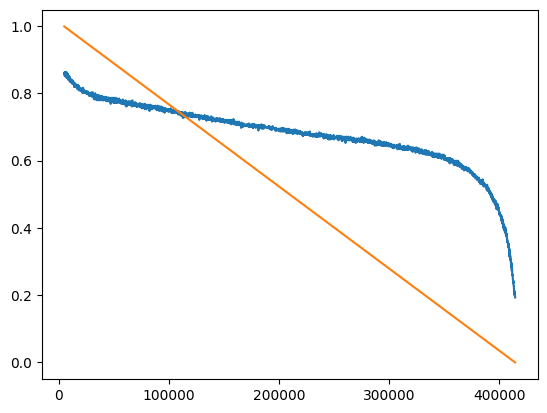

Epoch [10/100], Loss: 0.0001
Epoch [20/100], Loss: 0.0002
Epoch [30/100], Loss: 0.0002
Epoch [40/100], Loss: 0.0002
Epoch [50/100], Loss: 0.0002
Epoch [60/100], Loss: 0.0000
Epoch [70/100], Loss: 0.0004
Epoch [80/100], Loss: 0.0001
Epoch [90/100], Loss: 0.0002
Epoch [100/100], Loss: 0.0001


In [37]:
for d in train_dir:
    train_data = load_data(d)
    plt.plot(train_data[2], train_data[0])
    plt.plot(train_data[2], train_data[1])
    plt.show()
    dataloader = prep_data(train_data)
    train(num_epochs, dataloader, model, criterion, optimizer)

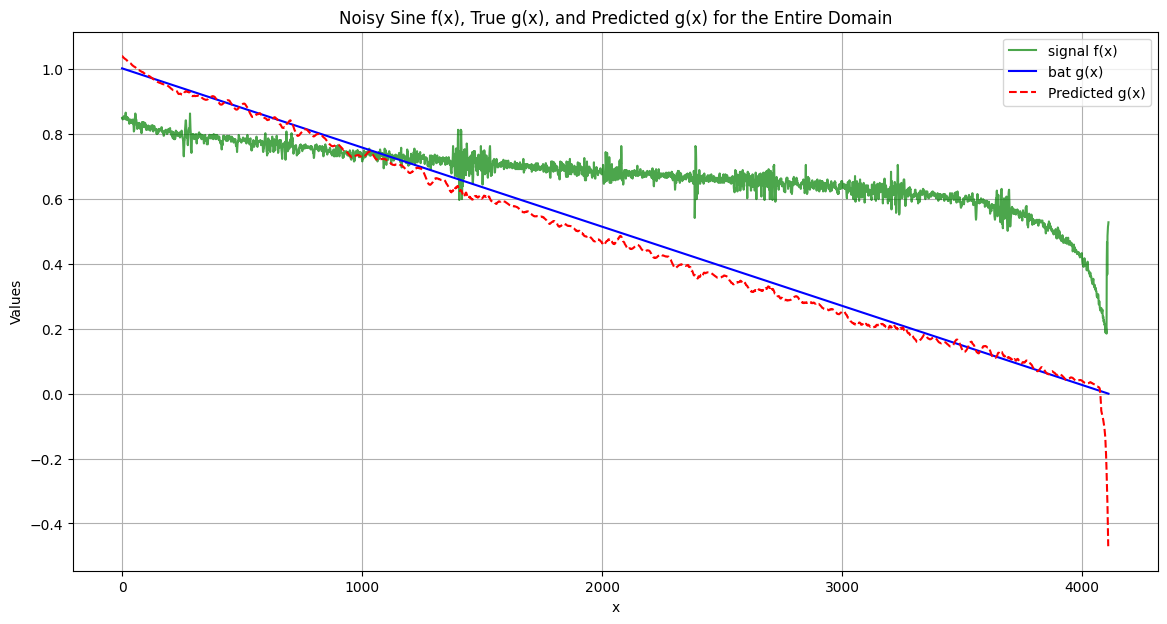

In [39]:
def test(train_data, model):
    g_tensor = torch.tensor(train_data[1], dtype=torch.float32)
    f_values, g_values, _ = train_data
    with torch.no_grad():
        predictions = []
        for i in range(len(train_data[0]) - n):  # Iterate over valid windows
            window = torch.tensor(train_data[0][i:i+n], dtype=torch.float32).unsqueeze(0)  # Get a window of size n
            pred = model(window)  # Predict g(x) for this window
            predictions.append(pred.squeeze())
    
    # Combine predictions
    predicted_g_full = torch.cat(predictions)
    
    # Since the windows overlap, we average the predictions for overlapping regions
    predicted_g_full_avg = torch.zeros_like(g_tensor)
    counts = torch.zeros_like(g_tensor)
    
    for i, pred in enumerate(predictions):
        # Ensure we don't exceed the bounds of predicted_g_full_avg
        end = min(i + n, len(predicted_g_full_avg))
        predicted_g_full_avg[i:end] += pred[:end - i]  # Assign only valid elements
        counts[i:end] += 1
    
    predicted_g_full_avg /= counts  # Average overlapping predictions
    
    plt.figure(figsize=(14, 7))
    
    indices = torch.arange(len(train_data[0]))  # Use the length of the data
    
    # Plot the noisy sine function f(x)
    plt.plot(indices, f_values, label='signal f(x)', color='green', linestyle='-', alpha=0.7)
    
    # Plot the true g(x)
    plt.plot(indices, g_values, label='bat g(x)', color='blue', linestyle='-')
    
    # Plot the predicted g(x)
    plt.plot(indices, predicted_g_full_avg.numpy(), label='Predicted g(x)', color='red', linestyle='--')
    
    # Add labels and legend
    plt.xlabel('x')
    plt.ylabel('Values')
    plt.legend()
    plt.title('Noisy Sine f(x), True g(x), and Predicted g(x) for the Entire Domain')
    plt.grid(True)
    plt.show()

for d in test_dir:
    test_data = load_data(d)
    test(test_data, model)

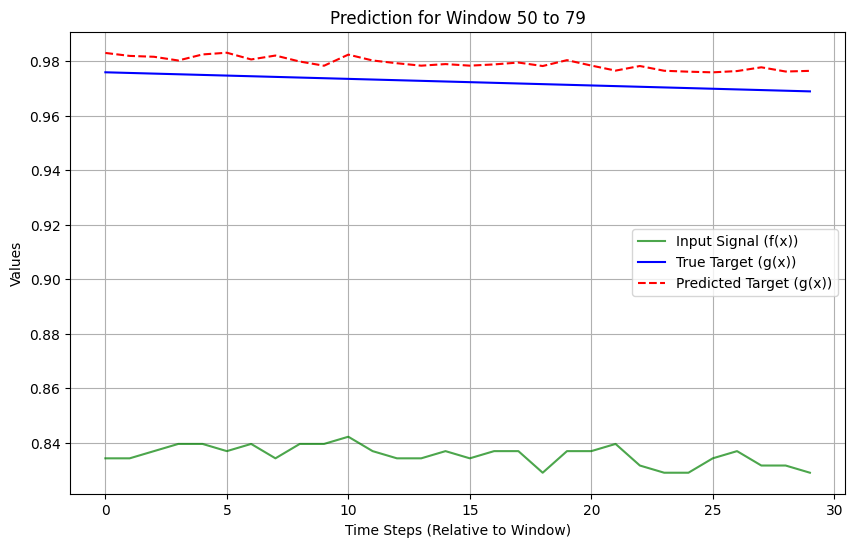

In [117]:
def test_single_window(test_data, model, n, window_index=0):
    f_values, g_values, _ = test_data  # Extract signal and tleft
    
    # Ensure the window_index is valid
    if window_index < 0 or window_index >= len(f_values) - n:
        raise ValueError(f"Invalid window_index. Must be between 0 and {len(f_values) - n - 1}.")
    
    # Extract the window of size `n`
    window = torch.tensor(f_values[window_index:window_index + n], dtype=torch.float32).unsqueeze(0)
    
    # Get the true target for this window
    true_target = torch.tensor(g_values[window_index:window_index + n], dtype=torch.float32)
    
    # Pass the window through the model
    with torch.no_grad():
        predicted_target = model(window).squeeze()
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    
    # Plot the input signal for the window
    plt.plot(range(n), f_values[window_index:window_index + n], 
             label='Input Signal (f(x))', color='green', linestyle='-', alpha=0.7)
    
    # Plot the true target for the window
    plt.plot(range(n), true_target.numpy(), 
             label='True Target (g(x))', color='blue', linestyle='-')
    
    # Plot the predicted target for the window
    plt.plot(range(n), predicted_target.numpy(), 
             label='Predicted Target (g(x))', color='red', linestyle='--')
    
    # Add labels and legend
    plt.xlabel('Time Steps (Relative to Window)')
    plt.ylabel('Values')
    plt.legend()
    plt.title(f'Prediction for Window {window_index} to {window_index + n - 1}')
    plt.grid(True)
    plt.show()

test_single_window(test_data, model, n, window_index=50)

In [119]:
# Save the state dictionary and architecture parameters
checkpoint = {
    'seq_length': n,
    'input_size': input_size,
    'hidden_size': hidden_size,
    'output_size': output_size,
    'cutoff': cutoff,
    'norm_upper': norm_upper,
    'norm_lower': norm_lower,
    'sec_norm': sec_norm,
    'state_dict': model.state_dict(),
}
torch.save(checkpoint, 'bat_seq_model.pth')